name: Praise Olukilede 
github username: thetosy
USC ID: 5768620607

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import metrics, losses
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
###from sklearn.metrics import classification_report



In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data


In [4]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    X.set_shape([299, 299, 3])
    y.set_shape([]) # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 8

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

2023-12-10 19:08:36.653014: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-10 19:08:36.653042: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 19:08:36.653046: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 19:08:36.653078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 19:08:36.653095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
print(len(tf_dataset_train), len(tf_dataset_test), len(tf_dataset_val))


3710 3710 1411


In [44]:
def getF1Score(precision, recall):
    f1 = 2 * ((precision * recall)/(precision + recall))
    print("F1 Score: " + str(round(f1,4)))

### (c) Training CNN + MLP
#### i. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation.

In [7]:
tf.random.set_seed(42)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness((-0.1, 0.1)),
    tf.keras.layers.RandomContrast(0.1),
    #tf.keras.layers.RandomCrop(299, 299),
    tf.keras.layers.Resizing(299, 299)
])

#### ii. Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization3 and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [8]:
model = Sequential()
# 1st 
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
#2nd
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
#3rd
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
# dense layer
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#output layer
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

In [9]:
batch_size = 8
epochs = 20

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    tf_dataset_train,
    epochs=epochs,
    steps_per_epoch=50,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)
'''
The output of the fit function has been deleted for all subsequent runs as it shows lines for each epoch run below is a sample of line shown

Epoch 1/20
2023-12-10 19:08:37.740708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-10 19:08:37.985771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-10 19:08:37.985839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-10 19:08:37.986045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
 2/50 [>.............................] - ETA: 9s - loss: 8.1599 - binary_accuracy: 0.6250 - precision: 0.8889 - recall: 0.6154  
2023-12-10 19:08:38.833175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-12-10 19:08:38.833204: I metal
'''



In [11]:
model.save('CNN.h5')

/Users/tosy/anaconda3/envs/opencv2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


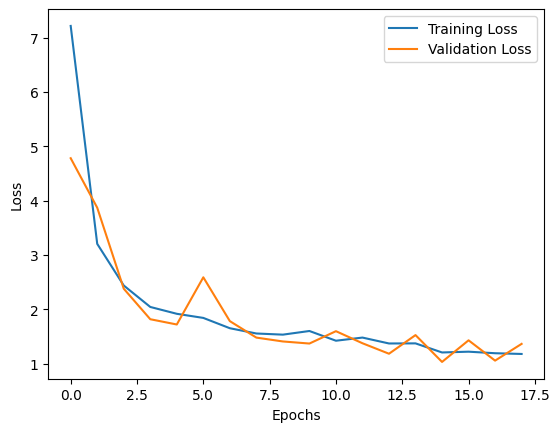

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
results = model.evaluate(tf_dataset_test)

3710/3710 [==============================] - 170s 46ms/step - loss: 1.0482 - binary_accuracy: 0.5941 - precision: 0.7507 - recall: 0.4631


In [45]:
getF1Score(0.7507, 0.4631)

F1 Score: 0.5728


### (d) Transfer Learning


using EfficientNetB0

In [14]:
efficient_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in efficient_base.layers:
    layer.trainable = False


In [17]:
input_layer = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(input_layer)
x = efficient_base(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
eff_model = Model(inputs=input_layer, outputs=predictions)
eff_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = eff_model.fit(
    tf_dataset_train,
    epochs=epochs,
    steps_per_epoch=50,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)


In [19]:
eff_model.save('eff_model.h5')

/Users/tosy/anaconda3/envs/opencv2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


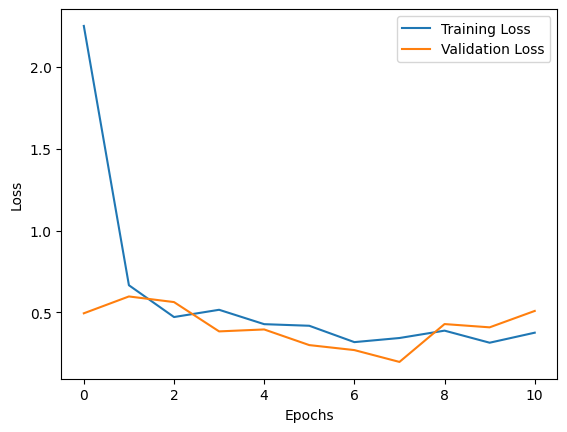

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
eff_results = eff_model.evaluate(tf_dataset_test)

3710/3710 [==============================] - 428s 115ms/step - loss: 0.2497 - binary_accuracy: 0.9072 - precision_2: 0.8960 - recall_2: 0.9526


In [26]:
getF1Score(0.8960, 0.9526)

F1 Score: 0.9234335172563021


Using the ResNet50

In [27]:
resNet = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in resNet.layers:
    layer.trainable = False

In [28]:
x1 = data_augmentation(input_layer)
x1 = resNet(x1)
x1 = GlobalAveragePooling2D()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(256, activation='relu')(x1)
predictions = Dense(1, activation='sigmoid')(x1)
res_model = Model(inputs=input_layer, outputs=predictions)
res_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

In [ ]:
history = res_model.fit(
    tf_dataset_train,
    epochs=epochs,
    steps_per_epoch=50,
    validation_data = tf_dataset_val,
    callbacks=[early_stopping]
)


In [35]:
res_model.save('res_model.h5')

/Users/tosy/anaconda3/envs/opencv2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


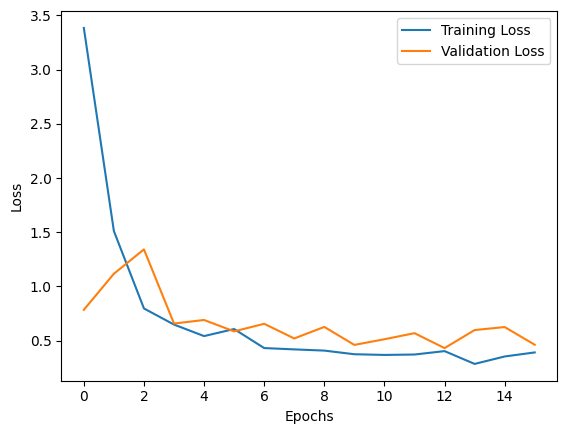

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
res_result = res_model.evaluate(tf_dataset_test)

3710/3710 [==============================] - 562s 152ms/step - loss: 0.3249 - binary_accuracy: 0.8723 - precision_3: 0.9677 - recall_3: 0.8098


In [37]:
getF1Score(0.9677, 0.8098)

F1 Score: 0.8817


Using the VGG16

In [38]:
vg_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in vg_model.layers:
    layer.trainable = False

In [39]:
x2 = data_augmentation(input_layer)
x2 = vg_model(x2)
x2 = GlobalAveragePooling2D()(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(256, activation='relu')(x2)
predictions = Dense(1, activation='sigmoid')(x2)
vgg_model = Model(inputs=input_layer, outputs=predictions)
vgg_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

In [ ]:
history = vgg_model.fit(
    tf_dataset_train,
    epochs=epochs,
    steps_per_epoch=50,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)

In [41]:
vgg_model.save('vgg_model.h5')

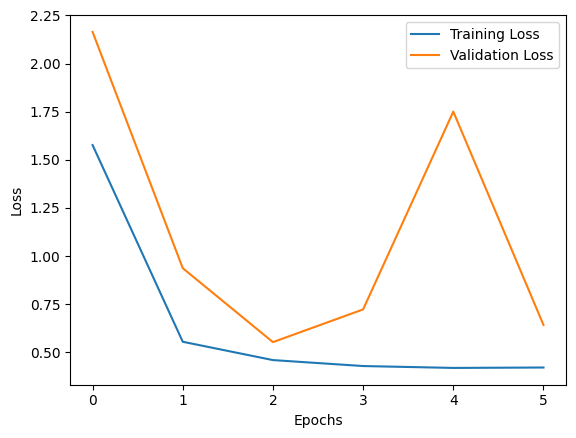

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
vgg_result = vgg_model.evaluate(tf_dataset_test)

3710/3710 [==============================] - 1073s 289ms/step - loss: 0.3638 - binary_accuracy: 0.8549 - precision_4: 0.9269 - recall_4: 0.8176


In [46]:
getF1Score(0.9269, 0.8176)

F1 Score: 0.8688


vi.  Compare the results of transfer learning with those of CNN + MLP model and explain them.

The CNN+MLP model reported a precision of 75% whereas all the other pre-trained models(transfer learning) recorded above 85% precision.

This shows that the pre-trained models which has been trained on thousands of data is a much better model than the CNN+MLP model 